In [1]:
#Dependencies
import psycopg2
%matplotlib inline
import matplotlib.pyplot as plt
from configparser import ConfigParser
import numpy as np
import pandas as pd
from urllib.parse import urlparse
from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings("ignore")

InteractiveShell.ast_node_interactivity = "all"

In [2]:
#necessary functions

def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

def date2RGB(date_list):
    num_list = list(map(lambda x: x.astype(int), date_list))
    u = np.unique(num_list)
    assert len(u) <= 999, "Too many inputs compared to number of colors"

    result = dict()
    for ind, num in enumerate(u):
        i = (num / 3)*255   
        r = (np.sin(0.024 * i + 0)+1)/2
        g = (np.sin(0.024 * i + 2)+1)/2
        b = (np.sin(0.024 * i + 4)+1)/2
        result[date_list[ind]] = (r,g,b)
    
    return result

def fetch_table(table_name, cur):
    q_tuples = '''SELECT * FROM %s'''

    q_columnName = '''SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = %s'''

    cur.execute(q_tuples % table_name)

    table_tuples = cur.fetchall()

    cur.execute(q_columnName, (table_name,))

    table_colums = cur.fetchall()

    table_colums = [i[0] for i in table_colums]

    return pd.DataFrame(table_tuples, columns=table_colums)

def rank_per_story(instories: pd.DataFrame, st_id: int, start_date:np.datetime64 = None, end_date:np.datetime64 = None):
    story_df = instories[instories['story_id'] == st_id]
    if start_date:
        story_df = story_df[story_df['published'] >= start_date]
    if end_date:
        story_df = story_df[story_df['published'] <= end_date]

    if len(story_df) == 0:
        story_df['rank'] = np.nan
        return story_df

    story_df.sort_values(by=['published'], inplace=True)
    story_df.reset_index(inplace=True, drop=True)

    time_delta = np.timedelta64(10, 'm')

    current_rank = 1
    current_time = story_df['published'][0]

    for i in range(len(story_df)):
        if story_df.loc[i, 'published'] > current_time + time_delta:
            current_rank += 1
            current_time = story_df.loc[i, 'published']
        story_df.loc[i, 'rank'] = current_rank
    
    story_df.loc[:,'rank'] = story_df['rank'].astype(np.int16)

    return story_df

def rank_time_delta(story_rank: pd.DataFrame):
    story_rank_sorted = story_rank.sort_values(by=['published'])
    ranks = story_rank['rank'].unique()
    time_deltas = {}
    for i in range(len(ranks)-1):
        latest_high = story_rank_sorted[story_rank_sorted['rank'] == ranks[i]].tail(1)
        earliest_low = story_rank_sorted[story_rank_sorted['rank'] == ranks[i+1]].head(1)
        time_delta = earliest_low['published'].values - latest_high['published'].values
        time_deltas[f'{ranks[i]}-{ranks[i+1]}'] = time_delta[0].astype('timedelta64[m]')
    return time_deltas

def flatten(t):
    return [item for sublist in t for item in sublist]

def Tat_media_filter(media_name):
    try:
        return known_media[media_name]
    except KeyError:
        return False

In [3]:
# read connection parameters
params = config()

# connect to the PostgreSQL server
print('Connecting to the PostgreSQL database...')
conn = psycopg2.connect(**params)

# create a cursor
cur = conn.cursor()
print('Connected to the PostgreSQL database...')

Connecting to the PostgreSQL database...
Connected to the PostgreSQL database...


In [4]:
fills_all = fetch_table('fills_all', cur)
instories = fetch_table('instories', cur)

In [5]:
fills_all['url_netloc'] = fills_all.url.apply(lambda x: urlparse(x).netloc.replace('www.',''))

In [6]:
fills_urlnetloc = fills_all.url.apply(lambda x: urlparse(x).netloc.replace('www.', '')).unique()

In [7]:
# netloc_name_dict = fills_all[['url_netloc', 'name']].set_index('url_netloc').to_dict()['name']

In [8]:
instories_urlnetloc = instories.page_url.apply(lambda x: urlparse(x).netloc.replace('www.', '')).unique()

In [9]:
known_media = set.intersection(set(fills_urlnetloc), set(instories_urlnetloc))
# known_media = set([netloc_name_dict[i] for i in known_media])
known_media = {i: True for i in known_media}

In [10]:
rank_df = None
time_delta_dict = {}

for story_id in instories.story_id.unique():
    rank_df_tmp = rank_per_story(instories, story_id)
    rank_df = pd.concat([rank_df_tmp, rank_df])
    time_delta_dict[story_id] = rank_time_delta(rank_df_tmp)

In [11]:
rank_df['url_netloc'] = rank_df.page_url.apply(lambda x: urlparse(x).netloc.replace('www.', ''))
rank_df.head() #rank by story_id

,story_id,media_name,published,headline,request_time,author,page_url,rank,url_netloc
0,179644805,Онлайн Тамбов.ру,2022-02-13 21:00:00,В конце февраля тамбовчан ожидает сокращённая ...,2022-02-15 18:12:56.040343,None,https://www.onlinetambov.ru/news/society/v-kon...,1,onlinetambov.ru
1,179644805,НТР 24,2022-02-15 16:00:00,Татарстанцам напомнили о грядущем праздничном ...,2022-02-15 18:12:56.040343,None,https://ntr-24.ru/index.php?newsid=90802&utm_s...,2,ntr-24.ru
2,179644805,Татар-информ,2022-02-15 17:00:00,Минтруд РТ: На следующей неделе татарстанцев ж...,2022-02-15 18:12:56.040343,None,https://www.tatar-inform.ru/news/mintrud-rt-na...,3,tatar-inform.ru
3,179644805,КП - Казань,2022-02-15 17:23:00,Минтруда Татарстана: 23 февраля в республики я...,2022-02-15 18:12:56.040343,None,https://www.kazan.kp.ru/online/news/4630716/,4,kazan.kp.ru
4,179644805,Вести Татарстан,2022-02-15 17:45:00,На следующей неделе татарстанцы будут отдыхать...,2022-02-15 18:12:56.040343,None,https://trt-tv.ru/news/na-sleduyushhej-nedele-...,5,trt-tv.ru


In [12]:
# count the number of times a media is at a particular rank

rank_count_df = pd.DataFrame(columns=['media_netloc', '1', '2', '3', '4', '5'])
rank_count_df['media_netloc'] = rank_df.url_netloc.unique()
rank_count_df.fillna(0, inplace=True)
for ind, row in rank_df.iterrows():
    rank = row['rank']
    if rank > 5:
        continue
    media_netloc = row.url_netloc
    index = rank_count_df[rank_count_df.media_netloc == media_netloc].index
    rank_count_df.loc[index, str(rank)] += 1
rank_count_df = pd.merge(rank_count_df, rank_df.url_netloc.value_counts().to_frame('count'), left_on='media_netloc', right_index=True)
rank_count_df['lower'] = rank_count_df.apply(lambda x: x['count'] - x['1'] - x['2'] - x['3']- x['4'] - x['5'], axis=1)

In [13]:
rank_count_df

,media_netloc,1,2,3,4,5,count,lower
0,onlinetambov.ru,1,0,0,0,0,1,0
1,ntr-24.ru,9,8,8,8,8,76,35
2,tatar-inform.ru,33,30,21,12,15,181,70
3,kazan.kp.ru,4,11,12,15,13,125,70
4,trt-tv.ru,5,14,5,16,18,131,73
...,...,...,...,...,...,...,...,...
266,islamnews.ru,0,0,1,0,0,1,0
267,culturavrn.ru,0,0,0,0,0,1,1
268,penzavzglyad.ru,0,0,0,0,0,1,1
269,typical-moscow.ru,0,0,0,0,0,1,1


## Overall (for all medias on market) data analytics (how fast, for now)

In [14]:
#divide the above dataframe by total number of article a media published to get the percentage

rank_percentage_df = rank_count_df.set_index('media_netloc')
rank_percentage_df[['1','2','3','4','5','lower']] = rank_percentage_df.apply(lambda x : x/x['count'], axis=1)[['1','2','3','4','5','lower']]

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'count'}>],
       [<AxesSubplot:title={'center':'lower'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

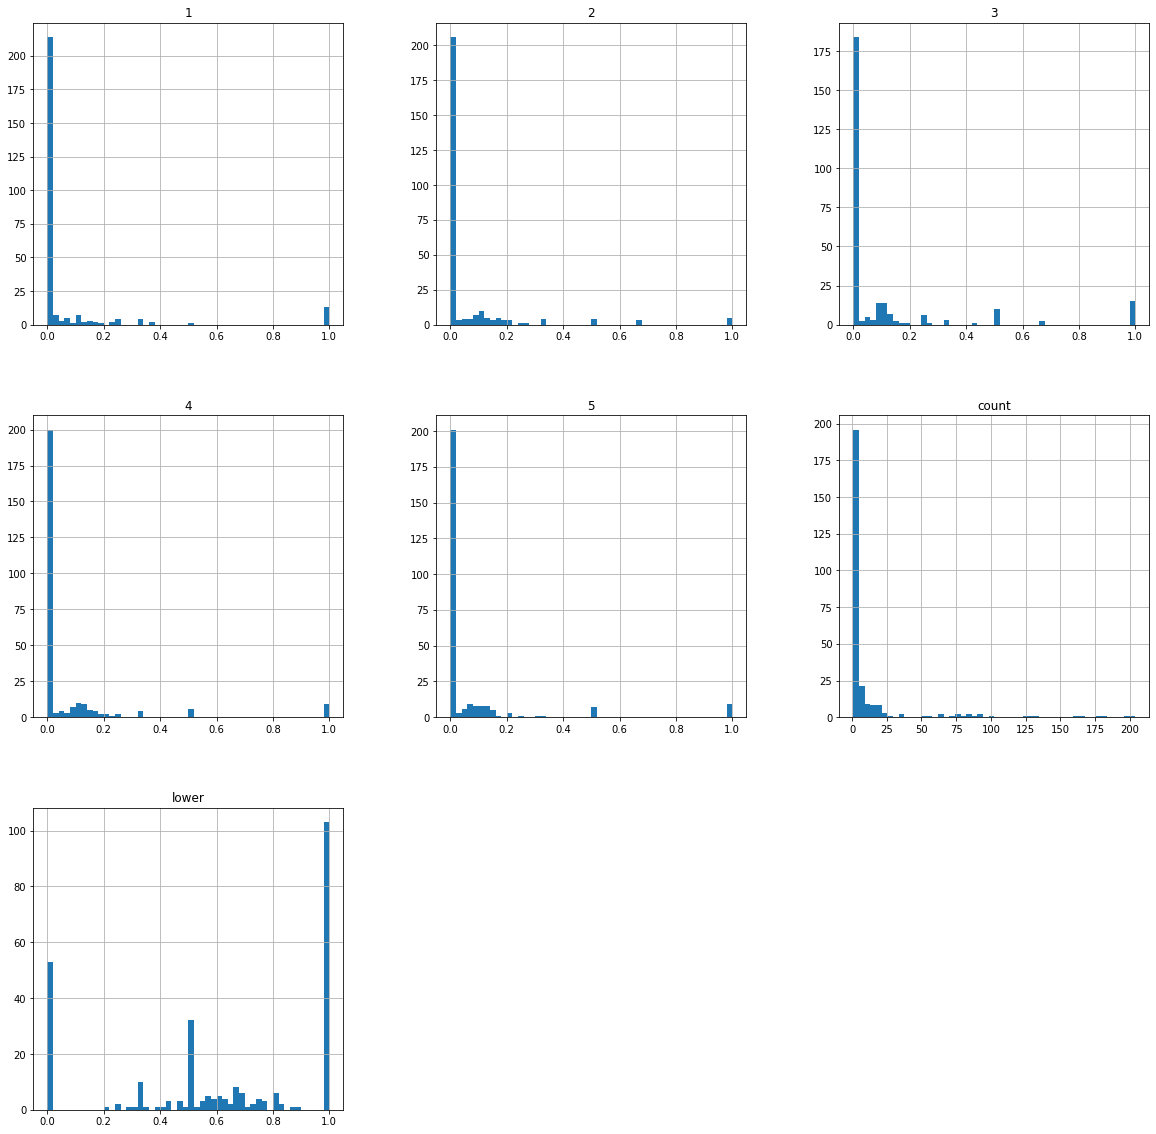

In [15]:
rank_percentage_df.hist(figsize=(20,20), bins=50)

In [16]:
rank_percentage_df.describe()

,1,2,3,4,5,count,lower
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000
mean,0.073285,0.059622,0.108532,0.072254,0.068374,13.162362,0.617933
std,0.221066,0.168417,0.248655,0.196447,0.195875,33.353597,0.376292
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.339286
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.666667
75%,0.000000,0.000000,0.092722,0.042080,0.033242,7.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,204.000000,1.000000


In [17]:
first_rank_3rd_quantile = rank_percentage_df.quantile([0.9])['1'][0.9]
#it should be 0.75, but I took 0.9 to get shorter list

In [ ]:
#showing the fastest ones among all medias on market
rank_percentage_df[rank_percentage_df['1'] >= first_rank_3rd_quantile].sort_values(['count','1','2','3','4','5','lower'], ascending=False)

## TatMedia data analytics (how fast, for now)

In [19]:
rank_count_df_TatMedia = rank_count_df[rank_count_df.media_netloc.apply(Tat_media_filter)]


In [20]:
rank_percentage_df_TatMedia = rank_count_df_TatMedia.set_index('media_netloc')
rank_percentage_df_TatMedia[['1','2','3','4','5','lower']] = rank_percentage_df_TatMedia.apply(lambda x : x/x['count'], axis=1)[['1','2','3','4','5','lower']]

In [21]:
# for ind, row in rank_percentage_df_TatMedia.iterrows():
#     fig, ax = plt.subplots()
#     row[['1','2','3','4','5','lower']].plot.pie(ax=ax)

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'count'}>],
       [<AxesSubplot:title={'center':'lower'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

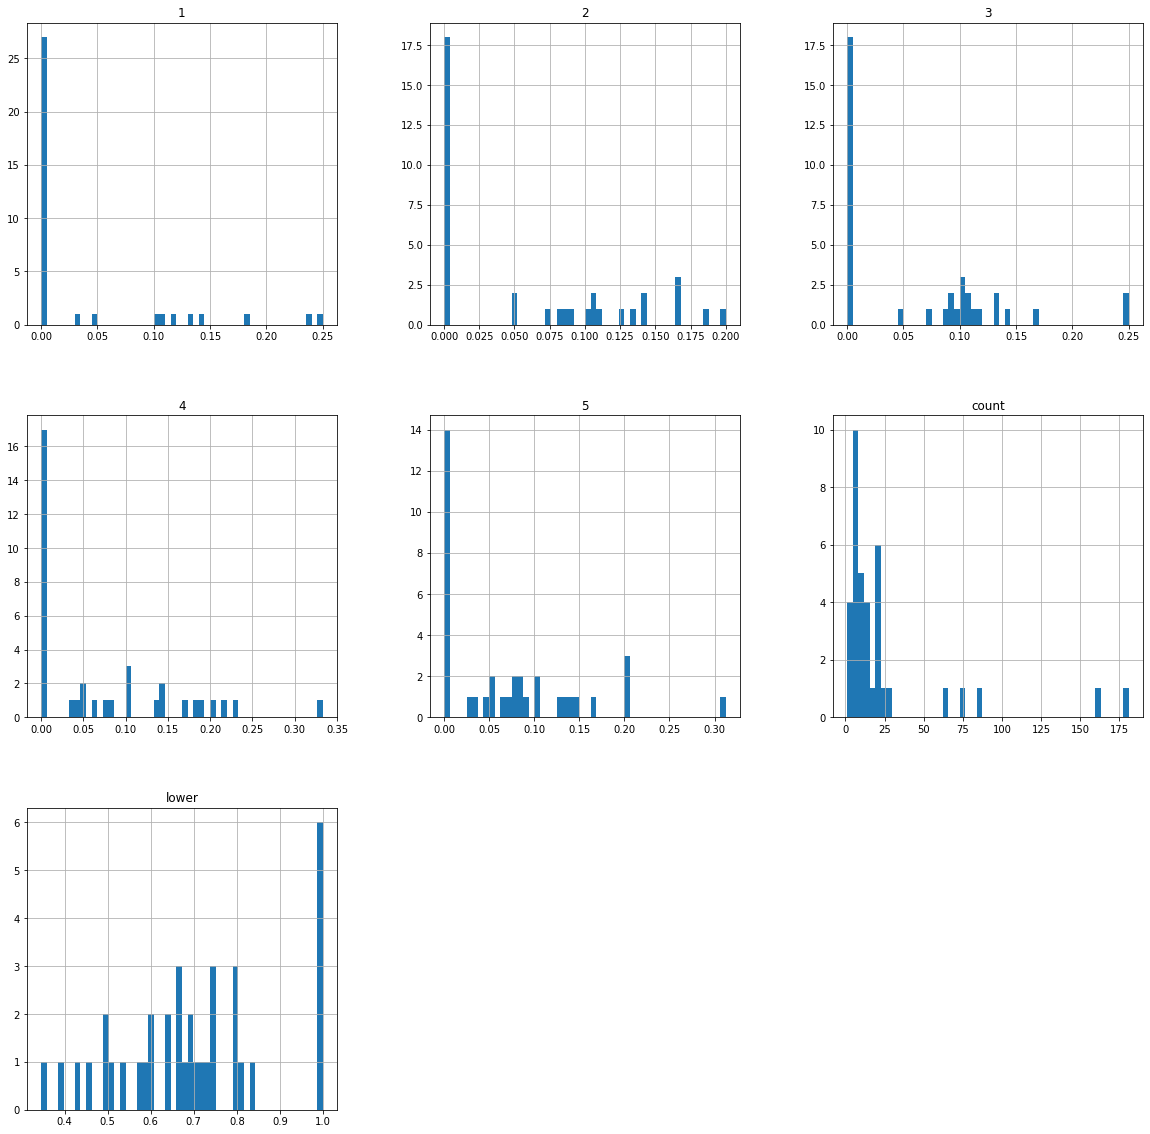

In [22]:
rank_percentage_df_TatMedia.hist(figsize=(20,20), bins=50)

In [23]:
rank_percentage_df_TatMedia.describe()

,1,2,3,4,5,count,lower
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.036519,0.061747,0.062147,0.071714,0.070528,25.270270,0.697344
std,0.070733,0.068317,0.071617,0.087112,0.076992,40.194422,0.179795
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.345238
25%,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.592593
50%,0.000000,0.050000,0.047619,0.045455,0.052632,11.000000,0.687500
75%,0.030864,0.111111,0.105263,0.135802,0.105263,21.000000,0.800000
max,0.250000,0.200000,0.250000,0.333333,0.312500,181.000000,1.000000


In [24]:
first_rank_3rd_quantile_TatMedia = rank_percentage_df_TatMedia.quantile([0.75])['1'][0.75]

In [ ]:
#showing the fastest ones among all medias of TatMedia
rank_percentage_df_TatMedia[rank_percentage_df_TatMedia['1'] >= first_rank_3rd_quantile_TatMedia].sort_values(['count','1','2','3','4','5','lower'], ascending=False)